In [1]:
import pandas as pd
import numpy as np
import os
import math
import datetime
%matplotlib inline
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
corr_loc = '/home/me/Documents/BWA/data/bw_hist_data/'
for i in os.listdir(corr_loc):
    if(".csv" not in i):
        os.remove(corr_loc+i)
        print(i)
    #print(i)

In [3]:
def get_test(sym):
    #corr_loc = '/home/me/Documents/BWA/data/bw_hist_data/'
    data = pd.read_csv(corr_loc+sym)
    #data['Open time'] = data['Open time']/1000
    #data['Open time'] = data['Open time'].astype('datetime64[s]')
    #data['Close time'] = data['Close time']/1000
    #data['Close time'] = data['Close time'].astype('datetime64[s]')
    #print(data.head())
    return data
def get_test2(sym):
    #corr_loc = '/home/me/Documents/BWA/data/bw_data/'
    data = pd.read_csv(corr_loc+sym)
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data['Close time'] = data['Close time']/1000
    data['Close time'] = data['Close time'].astype('datetime64[s]')
    #print(data.head())
    return data
def normalize(data):
    norm_close =  data["Close"].divide(data["Close"].iloc[0])
    return norm_close
def norm(data):
    norm = data[:]/data[0]
    return norm
    

PPTBTC4.csv
[6.85350054e-05 7.67561112e-05 8.35925096e-05 ... 6.84937514e-05
 6.84965652e-05 6.84991871e-05]


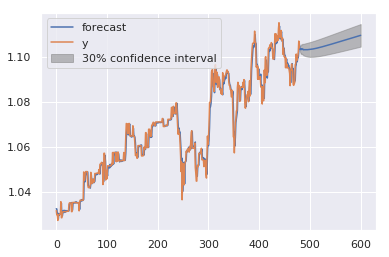

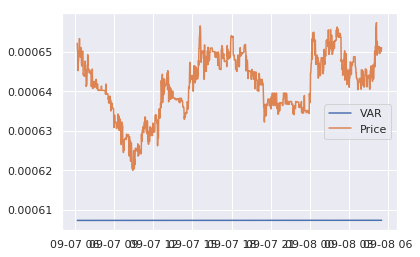

next symn


In [9]:

for i in os.listdir(corr_loc):
    curr_data = get_test(i)
    test_data = get_test2(i)
    print(i)#test_data.head()   
    close_data = normalize(curr_data)
    curr_data = curr_data.filter(['Close time','Close'])
   
    curr_data.index=curr_data['Close time']
    train_data = pd.read_csv(corr_loc+i)
    test_data = close_data.values
    model_csv = "./model_data.csv"
    var_model = VAR(curr_data[:-1400].values)
    var_model_fit = var_model.fit()
    
    arima_model = ARIMA(test_data[:-1400], order=(10,1,1))
    arima_model_fit = arima_model.fit()
    
    
    #plt.show()
    
    # make prediction
    arima_yhat = arima_model_fit.predict(1,1600)
    arima_model_fit.plot_predict(1000,1600, alpha=.7)
    var_yhat = var_model_fit.forecast(var_model_fit.y, steps=1400)
    print(arima_yhat)
    plt.show()
    predict = pd.DataFrame(var_yhat)
    predict[0] = predict[0]/1000
    predict[0] = predict[0].astype('datetime64[s]')
    #print(curr_data['Close'][-300:])
    plt.plot(predict[0],predict[1])
    plt.plot(predict[0],curr_data['Close'][-1400:])
    plt.legend(["VAR","Price"])
    plt.show()
    cont = input("next sym")
    if(cont=='n'):
        break
#take slope of prediction and create binary signal

#print(curr_data.head())
#norm_test = norm(test_data)
#print(train_data.head(),"\n", len(train_data))

In [ ]:
predict = None
predict = pd.DataFrame(var_yhat)
predict[0] = predict[0]/1000
predict[0] = predict[0].astype('datetime64[s]')
#print(curr_data['Close'][-300:])
plt.plot(predict[0],predict[1])
plt.plot(predict[0],curr_data['Close'][-1400:])
plt.legend(["VAR","Price"])

# Expected use case

I plan to use the arima model as a binary signal for whether to be short or long.
For futher predictive power I added a LSTM model below which creates a correlated data set for training each sym.

The correlation dataset consists of columns of normalized price data


In [ ]:
train_data = train_data.iloc[:,1:]
corr_matrix = train_data.values#as_matrix
print(corr_matrix.shape)
print(corr_matrix)

# Flattening dataset for training


In [19]:
data = corr_matrix.reshape(int(corr_matrix.shape[1])*int(corr_matrix.shape[0]))
print(data)
def create_dataset(dataset, look_back=100):
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    dataX,dataY = np.array(dataX),np.array(dataY)
    print(dataX.shape,dataY.shape)
    return dataX,dataY



[1.53673554e+12 2.63500000e-04 2.63700000e-04 ... 1.06730000e+02
 3.07868800e-02 0.00000000e+00]


In [25]:
ci = 0
#loop for each symbol in correlation "database"
for sym in os.listdir(corr_loc):
    curr_data = get_test(sym)
    #print(i)
    close_data = normalize(curr_data)
    curr_data = curr_data.filter(['Close time','Close'])
    train_data = pd.read_csv(corr_loc+sym)
    test_data = close_data.values
    #model_csv = "./model_data.csv"
    #print(curr_data.head())
    norm_test = norm(test_data)
    try:
        sym = sym.replace(".csv","")
        curr_data['Close time'] = (curr_data['Close time']/1000).astype('datetime64[ns]')
        curr_data.set_index('Close time',inplace=True, drop=True)
        print("====={} start datetime:{}=====".format(sym,curr_data.index[0]))
        train_data = train_data.iloc[:,1:]
        corr_matrix = train_data.values
        print(sym,corr_matrix.shape)
        total_len = 2880*len(train_data.columns)
        flattened_data = corr_matrix.reshape(total_len)
        print(flattened_data.shape)
        look_back = 10
        model = Sequential()
        model.add(LSTM(100, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        for c,i in enumerate(train_data.columns):
            if(c==9):
                break
            num_cols = len(train_data.columns)
            #print(num_cols)
            Xs = data[c::num_cols]
            print("XS:",Xs.shape)
            
            trainX, trainY = create_dataset(Xs, look_back)
            testX, testY = create_dataset(test_data, look_back)
            pct = (c/9)*100
            print("{}% trained for {}".format(pct,sym))
            # reshape input to be [samples, time steps, features]
            trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
            # fit
            model.fit(trainX, trainY, epochs=10, batch_size=100, verbose=0)
            
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))    
        model.fit(testX[1439:],testY[1439:], epochs=2)
        testPredict = model.predict(testX[:1439])
        model_data = pd.DataFrame(testPredict)
        test_data = pd.DataFrame(test_data)
        model_data.loc[-1] = 0
        shifted_2 = model_data.shift(2)
        concat_data = None
        concat_data = all_data[1440:]
        concat_data['norm_close'] = norm(norm_test[1440:])
        concat_data['shifted_2']= shifted_2.values
        concat_data['shifted_2'].fillna(method='bfill', inplace=True)
        concat_data['Norm Close'] = norm(concat_data['Close'])
        data, shft2 = model_strat(concat_data)
        model_dir = './model_outputs/'+sym+".csv"
        concat_data.to_csv(model_dir)
        print("====={} training complete!=====".format(sym))
        #if(ci%5==0):
            #time.sleep()
    except Exception as e:
        print(e)
#print(train_data.head(),"\n", len(train_data))

=====PPTBTC4 start datetime:1970-01-01 00:00:01.536211859=====
PPTBTC4 (2880, 12)
(34560,)
XS: (2880,)
(2869, 10) (2869,)
(2869, 10) (2869,)
0.0% trained for PPTBTC4
XS: (2880,)
(2869, 10) (2869,)
(2869, 10) (2869,)
11.11111111111111% trained for PPTBTC4
XS: (2880,)
(2869, 10) (2869,)
(2869, 10) (2869,)
22.22222222222222% trained for PPTBTC4


KeyboardInterrupt: 

In [ ]:
plt.plot(test_data)

In [ ]:
testPredict = model.predict(testX[:1439], verbose=1)

plt.plot(norm(testPredict),color='blue',linewidth=.6)
plt.plot(test_data[:1439], color='red', linewidth=.2)
#plt.plot(test_data)

In [ ]:

model_data = pd.DataFrame(testPredict)
test_data = pd.DataFrame(test_data)  
print(model_data[:60].describe())

In [ ]:
all_data = curr_data
#
#print(all_data.head())
model_pct = model_data.pct_change()
model_data.loc[-1] = 0
shifted_2 = model_data.shift(2)
shifted_3 = model_data.shift(3)
shifted_4 = model_data.shift(4)
shifted_5 = model_data.shift(5)

plt.plot(shifted_2[:500],color='red')
plt.plot(norm_test[:500])#
plt.legend(["prediction t+2","price"])


In [ ]:

concat_data = None
print(len(norm_test))
#print(model_data[0].head(3))
concat_data = all_data[1440:]
concat_data['norm_close'] = norm(norm_test[1440:])
print(len(concat_data), len(shifted_2))
#concat_data['Close'] = norm(concat_data['Close'])
#concat_data['model1']= model_data[0].values
concat_data['shifted_2']= shifted_2.values
concat_data['shifted_2'].fillna(method='bfill', inplace=True)
#print(model_data[0].describe())
#all_data['model_data'] = model_data[0].tolist()
print(concat_data.head())
concat_data.to_csv()

In [ ]:
print(concat_data.corr())
plt.plot(norm(concat_data['Close']))#[:200]))
plt.plot(concat_data['shifted_2'])#[:200])

In [ ]:
def get_bollinger(df,window):
    df = df.fillna(1)
    rolling_mean = df['Close'].rolling(window).mean()
    rolling_std = df['Close'].rolling(window).std()
    print(df.head(3))

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    df['Rolling Mean'] = rolling_mean
    df['Bollinger High'] = rolling_mean + (rolling_std * 1)
    df['Bollinger Low'] = rolling_mean - (rolling_std * 1)
    chart = df
    df['Short'] = None
    df['Long'] = None
    df['Position'] = None
    return chart

def bb_strat(df):    
    for row in range(len(df)):
    
        if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) and (df['Close'].iloc[row-1] < df['Bollinger High'].iloc[row-1]):
            df['Position'].iloc[row] = -1
        
        if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) and (df['Close'].iloc[row-1] > df['Bollinger Low'].iloc[row-1]):
            df['Position'].iloc[row] = 1
            
    df['Position'].fillna(method='ffill',inplace=True)
    
    df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
    
    return df['Strategy Return'].cumsum()
    #return chart
def model_strat(df):
    df['shifted_2'].fillna(1, inplace=True)
    df['Position'] = None
    ct = len(df)
    for row in range(len(df)):
        if(df['Norm Close'].iloc[row]>df['shifted_2'].iloc[row]) and (df['Norm Close'].iloc[row-1]<df['shifted_2'].iloc[row-1]):
            df['Position'].iloc[row] = 1
        if(df['Norm Close'].iloc[row]<df['shifted_2'].iloc[row]) and (df['Norm Close'].iloc[row-1]>df['shifted_2'].iloc[row-1]):
            df['Position'].iloc[row] = -1
        if(row%100==0):
            print("backtesting...{}% done".format((row/ct)*100))

    df['Position'].fillna(method='ffill',inplace=True)
    df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
    
    return df,df['Strategy Return'].cumsum()

    
#concat_data = concat_data.filter(['Close','shifted_2'])
concat_data['Norm Close'] = norm(concat_data['Close'])
chart = get_bollinger(concat_data,10)
print(concat_data.head())
data, shft2 = model_strat(concat_data)

In [ ]:
print("Profits:")
shift3 = shft2.reset_index()
shift3.plot()

In [ ]:
model_dir = './model_outputs/'+sym+".csv"
concat_data.to_csv(model_dir)
print(model_dir)

In [ ]:
print(chart.columns)
#
#print(norm(chart['Bollinger High'][:100]))
#plt.plot(chart['Close'][:100])
chart2 = chart.filter(['norm_close','shifted_2'])
chart2.plot()